## Dependencies
Import all the necessary dependencies

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob as glob
import time
import os
import math

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn import tree

from sklearn import linear_model
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV

from collections import deque
%matplotlib inline

#from multiprocessing import Process, Queue
print('sucessfully imported all the dependencies')

sucessfully imported all the dependencies


### Read images
Read all the images to train the classifier

In [2]:
noncarsfiles = glob.glob('training_data/non-vehicles/non-vehicles/**/*.png')
carfiles = glob.glob('training_data/vehicles/vehicles/**/*.png')

noncars = []
cars = []
for noncar in noncarsfiles:
    noncars.append(noncar)
    
for car in carfiles:
    cars.append(car)
    

print ("total number non cars:", len(noncars))


print ("total number cars:", len(cars))

total number non cars: 8968
total number cars: 8800


In [3]:
# Find HOG features


In [4]:
def find_hog_features(image, orientation, pixels, cells, verbose, f_vector=True):
    if verbose == True: 
        features, hog_image = hog(image, orientations=orientation, 
                                  pixels_per_cell=(pixels, pixels),
                                  cells_per_block=(cells, cells), 
                                  transform_sqrt=True, 
                                  visualise=verbose, feature_vector=f_vector)
        return features, hog_image
    else:      
        features = hog(image, orientations=orientation, 
                       pixels_per_cell=(pixels, pixels),
                       cells_per_block=(cells, cells), 
                       transform_sqrt=True, 
                       visualise=False, feature_vector=f_vector)
        return features

In [5]:
def binned_color_feature(image, bin_size): # size=(16, 16) size=(32, 32)
    color_r = cv2.resize(image[:,:,0], bin_size).ravel()
    color_g = cv2.resize(image[:,:,1], bin_size).ravel()
    color_b = cv2.resize(image[:,:,2], bin_size).ravel()
    return np.hstack((color_r, color_g, color_b))

In [6]:
def color_histogram(image, nbins):
    channel_r = np.histogram(image[:,:,0], bins=nbins, range=(0, 256))[0] 
    channel_g = np.histogram(image[:,:,1], bins=nbins, range=(0, 256))[0]
    channel_b = np.histogram(image[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((channel_r, channel_g, channel_b))
    return hist

In [7]:
def find_image_feature(feature_image, orientation, pixels, cells, nbins, bin_size, verbose, color_space):
    
    features =[]
    hog_feature = []
   
    # Feature 1
    color_hist_feature = color_histogram(feature_image, nbins)

    # Feature 2
    bin_color_feature = binned_color_feature(feature_image, bin_size)

    

    # Feature 3    
    feature_image_1 = feature_image[:,:,0]
    feature_image_2 = feature_image[:,:,1]
    feature_image_3 = feature_image[:,:,2]
    
    hog_feature_1=find_hog_features(feature_image_1, orientation, pixels, cells, verbose, f_vector=True)
    hog_feature_2=find_hog_features(feature_image_2, orientation, pixels, cells, verbose, f_vector=True)
    hog_feature_3=find_hog_features(feature_image_3, orientation, pixels, cells, verbose, f_vector=True)
    
    hog_feature = np.hstack((hog_feature_1, 
                             hog_feature_2,
                             hog_feature_3))
    
    #hog_feature.append(feature)
        
    features.append(color_hist_feature)
    features.append(bin_color_feature)
    features.append(hog_feature)
        
    return features    

In [8]:
def find_features(files, orientation, pixels, cells, nbins, bin_size, verbose, color_space):

    concat_features = []
    
    # Iterate through the list of images
    for img_location in files: 
        features = []        
        image = mpimg.imread(img_location)# Read image in RGB format
        
        if color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YCR_CB':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

        original_features=find_image_feature(image, orientation, pixels, cells, nbins, bin_size, verbose, color_space)
        
        concat_features.append(np.concatenate(original_features))               
        
    return concat_features

In [9]:
pixels = 8 
cells = 2 
orientation = 12 
bin_size = (32,32)
nbins = 32 
verbose=False 
color_channel=1
color_space = ['LUV', 'HSV', 'HLS', 'YCR_CB', 'RGB', 'YUV']
print("All variables defined")

All variables defined


# Feature extraction
Extract features from all the training images

In [10]:
def find_car_features(color_space):
    car_features = find_features(cars, orientation, pixels, cells, nbins, bin_size, verbose, color_space)    
    return car_features

In [11]:
def find_non_car_features(color_space):
    non_car_features = find_features(noncars, orientation, pixels, cells, nbins, bin_size, verbose, color_space)
    return non_car_features

In [12]:
car_features = []
non_car_features = []
print("NO OF COLOR SPACES: ", len(color_space))
for index in range(0, len(color_space)):    
    car_features.append(find_car_features(color_space=color_space[index]))
    non_car_features.append(find_non_car_features(color_space=color_space[index]))
    print("collected all the features in ", color_space[index], " color space" )

NO OF COLOR SPACES:  6


/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


collected all the features in  LUV  color space
collected all the features in  HSV  color space
collected all the features in  HLS  color space
collected all the features in  YCR_CB  color space
collected all the features in  RGB  color space
collected all the features in  YUV  color space


In [13]:
def svm_train_classifier():
    
    accuracy =[]
    classifier=[]
    scaler=[]
    for index in range(0, len(color_space)):
        #print('index', index)
        
        X = np.vstack((car_features[index], non_car_features[index])).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features[index])), np.zeros(len(non_car_features[index]))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)

        # Use a linear SVC 
        svc = LinearSVC()
        # Check the training time for the SVC
        t=time.time()
        svc.fit(X_train, y_train)
        
        # Accuracy 
        test_accuracy = svc.score(X_test, y_test)
        print('Test Accuracy of SVC in', color_space[index], ' is ', ' = ', test_accuracy, ' in ', time.time()-t,' seconds' )
        accuracy.append((test_accuracy, index))
        
        classifier.append(svc)
        scaler.append(X_scaler)
        
    return classifier, scaler
       

In [14]:
def d_tree_train_classifier():
    
    accuracy =[]
    classifier=[]
    scaler=[]
    for index in range(0, len(color_space)):
        #print('index', index)
        
        X = np.vstack((car_features[index], non_car_features[index])).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features[index])), np.zeros(len(non_car_features[index]))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)

        # Use decission tree 
        clf = tree.DecisionTreeClassifier()
        # Check the training time for the SVC
        t=time.time()
        clf.fit(X_train, y_train)
        
        # Accuracy 
        test_accuracy = clf.score(X_test, y_test)
        print('Test Accuracy of d_tree in', color_space[index], ' is ', ' = ', test_accuracy, ' in ', time.time()-t,' seconds' )
        accuracy.append((test_accuracy, index))
        
        classifier.append(clf)
        scaler.append(X_scaler)
        
    return classifier, scaler

In [15]:
def sgd_train_classifier():
    
    accuracy =[]
    classifier=[]
    scaler=[]
    for index in range(0, len(color_space)):
        #print('index', index)
        
        X = np.vstack((car_features[index], non_car_features[index])).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features[index])), np.zeros(len(non_car_features[index]))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)

        # Use SGD
        clf = linear_model.SGDClassifier()        # Check the training time for the SVC
        t=time.time()
        clf.fit(X_train, y_train)
        
        # Accuracy 
        test_accuracy = clf.score(X_test, y_test)
        print('Test Accuracy of sgd in', color_space[index], ' is ', ' = ', test_accuracy, ' in ', time.time()-t,' seconds' )
        accuracy.append((test_accuracy, index))
        
        classifier.append(clf)
        scaler.append(X_scaler)
        
    return classifier, scaler

In [16]:
def omp_train_classifier():
    
    accuracy =[]
    classifier=[]
    scaler=[]
    for index in range(0, len(color_space)):
        #print('index', index)
        
        X = np.vstack((car_features[index], non_car_features[index])).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features[index])), np.zeros(len(non_car_features[index]))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)

        # Use omp
        clf = OrthogonalMatchingPursuitCV()
        t=time.time()
        clf.fit(X_train, y_train)
        
        # Accuracy 
        test_accuracy = clf.score(X_test, y_test)
        print('Test Accuracy of omp in', color_space[index], ' is ', ' = ', test_accuracy, ' in ', time.time()-t,' seconds' )
        accuracy.append((test_accuracy, index))
        
        classifier.append(clf)
        scaler.append(X_scaler)
        
    return classifier, scaler

In [17]:
svc, X_scaler = svm_train_classifier()

Test Accuracy of SVC in LUV  is   =  0.983117613956  in  40.136717081069946  seconds
Test Accuracy of SVC in HSV  is   =  0.983117613956  in  35.43988490104675  seconds
Test Accuracy of SVC in HLS  is   =  0.981992121553  in  34.38728380203247  seconds
Test Accuracy of SVC in YCR_CB  is   =  0.980303882949  in  33.973474740982056  seconds
Test Accuracy of SVC in RGB  is   =  0.976083286438  in  33.38496804237366  seconds
Test Accuracy of SVC in YUV  is   =  0.980022509848  in  36.07208728790283  seconds


In [18]:
clf, clf_X_scaler = d_tree_train_classifier()

Test Accuracy of d_tree in LUV  is   =  0.905740011255  in  377.10723662376404  seconds
Test Accuracy of d_tree in HSV  is   =  0.907428249859  in  291.5932502746582  seconds
Test Accuracy of d_tree in HLS  is   =  0.906865503658  in  351.1618928909302  seconds
Test Accuracy of d_tree in YCR_CB  is   =  0.903207653348  in  366.9865119457245  seconds
Test Accuracy of d_tree in RGB  is   =  0.910804727068  in  318.3489656448364  seconds
Test Accuracy of d_tree in YUV  is   =  0.920371412493  in  337.1887891292572  seconds


In [19]:
clf_sgd, clf_sgd_X_scaler = sgd_train_classifier()

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Test Accuracy of sgd in LUV  is   =  0.976646032639  in  1.3133013248443604  seconds
Test Accuracy of sgd in HSV  is   =  0.971862689927  in  1.3413865566253662  seconds
Test Accuracy of sgd in HLS  is   =  0.975801913337  in  1.2988853454589844  seconds
Test Accuracy of sgd in YCR_CB  is   =  0.968204839617  in  1.300750970840454  seconds
Test Accuracy of sgd in RGB  is   =  0.976083286438  in  1.2937016487121582  seconds
Test Accuracy of sgd in YUV  is   =  0.970174451322  in  1.3382856845855713  seconds


In [20]:
clf_omp, clf_omp_X_scaler = omp_train_classifier()

Test Accuracy of omp in LUV  is   =  0.819591049262  in  206.8114879131317  seconds
Test Accuracy of omp in HSV  is   =  0.821782165565  in  209.38108229637146  seconds
Test Accuracy of omp in HLS  is   =  0.829779298271  in  206.27019953727722  seconds
Test Accuracy of omp in YCR_CB  is   =  0.820469965268  in  223.94852423667908  seconds
Test Accuracy of omp in RGB  is   =  0.822866082506  in  218.14390516281128  seconds
Test Accuracy of omp in YUV  is   =  0.827968576692  in  211.00104022026062  seconds


# Classifiers

Support Vector Machine(SVM), decission trees, stochastic gradient descent classifier(SGD), Orthogonal Matching Pursuit model(OMP) are trained and the accuracies are compared. 
The decission trees are way too slower than svm as well as the accuracy is also lower.

The SGD has in general higher accuracy and is also faster than SGD. The accuracy of OMP is also comparitively lower than SGD or SVM classifiers.

**References:**  
[ Orthogonal Matching Pursuit-OMP](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.OrthogonalMatchingPursuit.html)  
[stochastic gradient descent classifier-SGD](http://scikit-learn.org/stable/modules/sgd.html)  
[Decision trees](http://scikit-learn.org/stable/modules/tree.html)  
[Support Vector Machine-SVM](http://scikit-learn.org/stable/modules/svm.html)  


In [21]:
print('Training is done with all the classifiers ...')

Training is done with all the classifiers ...


In [22]:
def slide_window(img, window, overlap, x_coord, y_coord):
    if x_coord[0] == None:
        x_coord[0] = 0
    if x_coord[1] == None:
        x_coord[1] = img.shape[1]
    if y_coord[0] == None:
        y_coord[0] = 0
    if y_coord[1] == None:
        y_coord[1] = img.shape[0]
       
    xspan = x_coord[1] - x_coord[0]
    yspan = y_coord[1] - y_coord[0]
    
    # Compute the number of pixels per step in x/y
    # Like 16 x 16 or 32 x 32 or 64 x 64 
    step_x = np.int(window[0]*(1 - overlap[0]))
    step_y = np.int(window[1]*(1 - overlap[1]))
    
    #print("step_x", step_x)
    #print("step_y", step_y)
    # Compute the number of windows in x/y
    nx_buffer = np.int(window[0]*(overlap[0]))
    ny_buffer = np.int(window[1]*(overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/step_x) 
    ny_windows = np.int((yspan-ny_buffer)/step_y) 

    #print("ny_windows", range(ny_windows))
    #print("nx_windows", range(nx_windows))
    window_list = []

    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*step_x + x_coord[0]
            endx = startx + window[0]
            starty = ys*step_y + y_coord[0]
            endy = starty + window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


## Drawing bounding boxes
Drawing windows on the image using the bounding boxes that are found using the sliding window method

In [23]:
def draw_windows(img, bboxes, color=(0, 0, 255), thickness=7):    
    imcopy = np.copy(img) # Make a copy of the image
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thickness)

    return imcopy

## Find cars

Find cars in the image

In [24]:
def find_cars(image, windows, index):  
    boxes = []
    i=1
    j=0
    
    for window in windows:        
        
        crop_img = image[window[0][1]:window[1][1], window[0][0]:window[1][0]]
        test_img = cv2.resize(crop_img, (64, 64))
        color = color_space[index]
        concat_features = find_image_feature(test_img, orientation, pixels, cells, nbins, bin_size, verbose=False, color_space=color)        

        features = np.concatenate(concat_features)

        # Use decission tree or SVM  or SGD or  OMP     
        test_features = X_scaler[index].transform(np.array(features).reshape(1, -1))
        #test_features = clf_X_scaler[index].transform(np.array(features).reshape(1, -1))
        #test_features = clf_sgd_X_scaler[index].transform(np.array(features).reshape(1, -1))
        #test_features = clf_omp[index].transform(np.array(features).reshape(1, -1))
                
        test_prediction = svc[index].predict(test_features)
        #test_prediction = clf[index].predict(test_features)
        #test_prediction = clf_sgd[index].predict(test_features)
        #test_prediction = clf_omp_X_scaler[index].predict(test_features)
        
        if test_prediction == 1:
            j=j+1
            #print(window[0][0], " , ", window[0][1])
            #print(window[0][0], " , ", window[1][0])
            boxes.append(window)
        i=i+1
    #print(j, ' of ', i, ' windows are cars')
    return boxes

In [25]:
def find_heatmap(heatmap, bounding_boxes):    
    for box in bounding_boxes:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]]+=1
    
    return heatmap

In [26]:
def threshold(heatmap, threshold):    
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [27]:
# Assuming cars are of sizes 160x120

car_size_x=160
car_size_y=120

def draw_cars(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        #bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.min(nonzerox)+car_size_x, np.min(nonzeroy)+car_size_y))
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    return img

In [86]:
#b_box_previous_frame = []
first_scan = True
previous_frames = deque(maxlen=10)

def test_images(index, verbose):
    test_imgs = glob.glob('test_images/*.jpg')

    bounding_boxes =[]
    test_images = []
    
    i=0
    for img in test_imgs:
       # print(img)
        image = cv2.imread(img)
        #image = mpimg.imread(img)
        test_images.append(img)
        overlap = 0.85
       
        heat_threshold = 20 
        #windows_1_1 = slide_window(image, x_coord=[800, None], y_coord=[380, 680], 
        #                           window=(160, 160), overlap=(overlap, overlap))   
        windows_1_2 = slide_window(image, x_coord=[800, None], y_coord=[360, 550], 
                                   window=(128, 128), overlap=(overlap, overlap))  

        #windows_2_1 = slide_window(image, x_coord=[100, 400], y_coord=[380, 650], 
        #                           window=(160, 160), overlap=(overlap, overlap))    
        windows_2_2 = slide_window(image, x_coord=[100, 400], y_coord=[360, 500], 
                                   window=(128, 128), overlap=(overlap, overlap))

        windows_3_1 = slide_window(image, x_coord=[750, None], y_coord=[400, 470], 
                                 window=(64, 64), overlap=(overlap, overlap))
        #windows_3_2 = slide_window(image, x_coord=[100, 400], y_coord=[400, 470], 
        #                         window=(64, 64), overlap=(overlap, overlap))

        b_box =[]

        #b_box += (find_cars(image, windows_1_1, index))
        b_box += (find_cars(image, windows_1_2, index))
        #b_box += (find_cars(image, windows_2_1, index))
        b_box += (find_cars(image, windows_2_2, index))
        b_box += (find_cars(image, windows_3_1, index))
        #b_box += (find_cars(image, windows_3_2, index))   
        
        
        global first_scan, previous_frames
        if first_scan:
            previous_frames.extend(b_box)        

            first_scan=False

        heatmap_previous=np.zeros_like(image[:,:,0]).astype(np.float)
        heat_map_previous=find_heatmap(heatmap_previous, previous_frames)
        
        heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
        heat_map=find_heatmap(heatmap, b_box)
        
        heatmap_sum = np.add(heat_map_previous,heat_map)
        
        heat = threshold(heatmap_sum,heat_threshold)
              
        heat_clip = np.clip(heat, 0,255)
        
        labels = label(heat_clip)
        car_box = draw_cars(cv2.imread(img) , labels)
                
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cars_rgb = cv2.cvtColor(car_box, cv2.COLOR_BGR2RGB)
        
        f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 18))
        ax1.imshow(image_rgb)
        ax1.set_title('Original', fontsize=15)
        ax2.imshow(cars_rgb)
        ax2.set_title('cars', fontsize=15)
        plt.show()
        
        if i==5:
            #sliding_1_1 = draw_windows(image, windows_1_1, color=(255, 0, 255), thickness=7)
            sliding_1_2 = draw_windows(image, windows_1_2, color=(255, 100, 255), thickness=7)
            #sliding_2_1 = draw_windows(image, windows_2_1, color=(100, 255, 255), thickness=7)
            sliding_2_2 = draw_windows(image, windows_2_2, color=(20, 255, 255), thickness=7)
            sliding_3_1 = draw_windows(image, windows_3_1, color=(100, 0, 255), thickness=7)
            #sliding_3_2 = draw_windows(image, windows_3_2, color=(0, 100, 255), thickness=7)
            
            #sliding_1_1_rgb = cv2.cvtColor(sliding_1_1, cv2.COLOR_BGR2RGB)
            sliding_1_2_rgb = cv2.cvtColor(sliding_1_2, cv2.COLOR_BGR2RGB)
            #sliding_2_1_rgb = cv2.cvtColor(sliding_2_1, cv2.COLOR_BGR2RGB)
            sliding_2_2_rgb = cv2.cvtColor(sliding_2_2, cv2.COLOR_BGR2RGB)
            sliding_3_1_rgb = cv2.cvtColor(sliding_3_1, cv2.COLOR_BGR2RGB)
            #sliding_3_2_rgb = cv2.cvtColor(sliding_3_2, cv2.COLOR_BGR2RGB)
            
            #plt.imshow(sliding_1_1_rgb)
            #plt.show()
            plt.imshow(sliding_1_2_rgb)
            plt.show()
            #plt.imshow(sliding_2_1_rgb)
            #plt.show()
            plt.imshow(sliding_2_2_rgb)
            plt.show()
            plt.imshow(sliding_3_1_rgb)
            plt.show()
            #plt.imshow(sliding_3_2_rgb)
            #plt.show()
            plt.imshow(heat_clip)
            plt.show()
            
        i=i+1
        previous_frames.extend(b_box)
    print ("Total number Test images:", len(test_images))
    

In [72]:
index=5

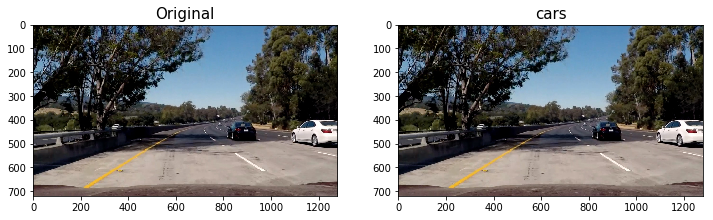

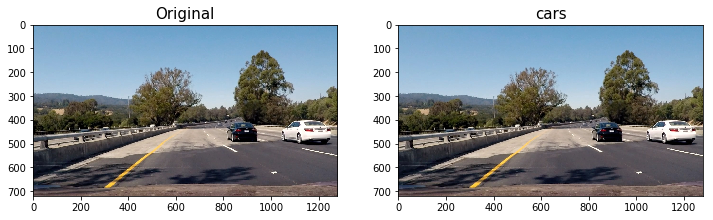

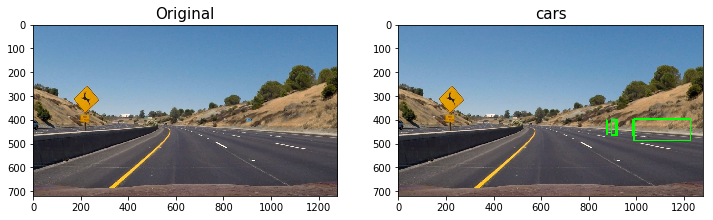

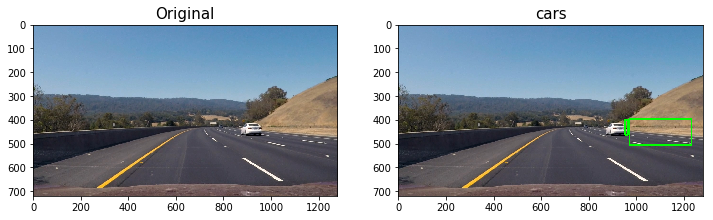

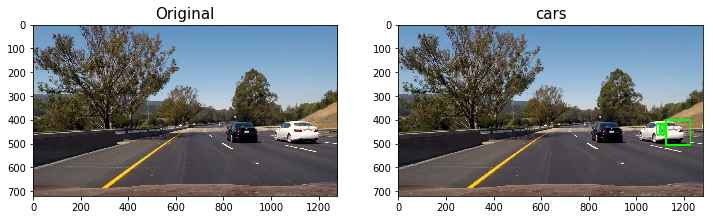

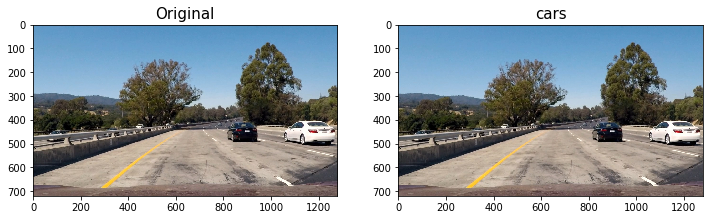

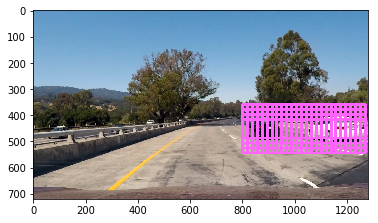

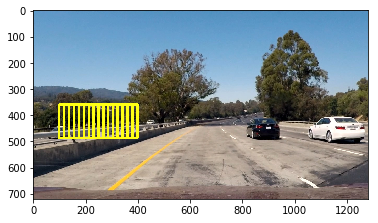

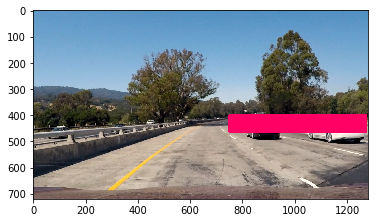

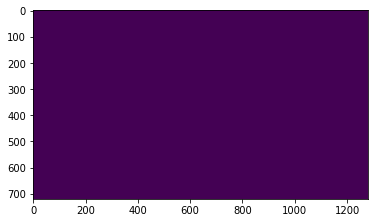

Total number Test images: 6


In [88]:
test_images(index=index, verbose=1)

# pipeline

The pipeline to process an image, find the cars and draw bounding boxes around.

In [31]:
remember = 20

In [84]:

#b_box_previous_frame = []
first_time = True
b_box_previous_frame = deque(maxlen=remember)
def pipeline(image):   
    
    bounding_boxes =[]
    test_images = []
    overlap =0.85
   
   
    heat_threshold = 20 
    #windows_1_1 = slide_window(image, x_coord=[800, None], y_coord=[380, 680], 
    #                           window=(160, 160), overlap=(overlap, overlap))   
    windows_1_2 = slide_window(image, x_coord=[800, None], y_coord=[360, 550], 
                               window=(128, 128), overlap=(overlap, overlap))  

    #windows_2_1 = slide_window(image, x_coord=[100, 400], y_coord=[380, 650], 
    #                           window=(160, 160), overlap=(overlap, overlap))    
    windows_2_2 = slide_window(image, x_coord=[100, 400], y_coord=[360, 500], 
                               window=(128, 128), overlap=(overlap, overlap))

    windows_3_1 = slide_window(image, x_coord=[750, None], y_coord=[400, 470], 
                             window=(64, 64), overlap=(overlap, overlap))
    #windows_3_2 = slide_window(image, x_coord=[100, 400], y_coord=[400, 470], 
    #                         window=(64, 64), overlap=(overlap, overlap))

    b_box =[]

    #b_box += (find_cars(image, windows_1_1, index))
    b_box += (find_cars(image, windows_1_2, index))
    #b_box += (find_cars(image, windows_2_1, index))
    b_box += (find_cars(image, windows_2_2, index))
    b_box += (find_cars(image, windows_3_1, index))
    #b_box += (find_cars(image, windows_3_2, index))    
    
    
    global first_time, b_box_previous_frame
    
    if first_time:
        b_box_previous_frame.extend(b_box)        
        
        first_time=False
    
    heatmap_previous=np.zeros_like(image[:,:,0]).astype(np.float)
    heat_map_previous=find_heatmap(heatmap_previous, b_box_previous_frame)
    
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heat_map=find_heatmap(heatmap, b_box)
    
    heatmap_sum = np.add(heat_map_previous,heat_map)
    heat = threshold(heatmap_sum,heat_threshold)

    heat_clip = np.clip(heat, 0 ,255)

    labels = label(heat_clip)
    car_box = draw_cars(image, labels)
        
    b_box_previous_frame.extend(b_box)
        
    return car_box

In [83]:
from moviepy.editor import VideoFileClip

print('Using color space: ', color_space[index])
output_v = 'test_video_output.mp4' #project_video_output
clip1 = VideoFileClip("test_video.mp4") #project_video
clip = clip1.fl_image(pipeline)

%time clip.write_videofile(output_v, audio=False)

Using color space:  YUV
[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:25<00:00,  1.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 25 s, sys: 180 ms, total: 25.2 s
Wall time: 26.1 s


In [85]:
output_v = 'project_video_output.mp4' #project_video_output
clip1 = VideoFileClip("project_video.mp4") #project_video
clip = clip1.fl_image(pipeline)

%time clip.write_videofile(output_v, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [14:00<00:00,  1.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 13min 57s, sys: 2.82 s, total: 14min
Wall time: 14min 1s


In [77]:
print('Sucessfully completed ...')

Sucessfully completed ...
